# Fairness em Sistemas de Recomendação


Harald Steck, demonstrou que alguns algoritmos de recomendação, que são treinados baseados em aumentar a acurácia, tendem a gerar listas de recomendações focadas apenas nos gostos mais frequentes dos usuários, ignorando os outros gostos que o usuário tem. Ou seja, em um sistema afetado por isso, ao longo do tempo, as recomendações carregam o risco de afetar as áreas de interesse do usuário, o qual é um efeito similar ao ``echo-chamber``, descrito por outros pesquisadores da área.

Steck atribuiu esse problema a classe de problemas de justiça (fairness) e criou algumas heurísticas para reduzir-lo.

Nesse notebook, vamos explorar a injustiça relacionada a recomendação de gêneros. Iremos visualizar como os gostos de alguns usuários se distribuem e como os sistemas de recomendação lidam com isso. Por fim, vamos implementar a técnica proposta por Harald Steck e observar como isso afeta os gêneros de filmes recomendados para alguns usuários.



---

## Tabela de Conteudos

0. [Download do Dataset](#0.-Download-do-Dataset-)

1. [Carregando e Visualizando o Dataset](#1.-Carregando-e-visualizando-o-dataset)

2. [Carregando informações de genero dos filmes](#2.-Carregando-informações-de-genero-dos-filmes)

3. [Divisão da Base em Treino e teste](#3.-Divisão-da-base-em-treino-e-teste)

4. [Observando os generos consumidos pelos usuarios](#4.-Observando-os-generos-consumidos-pelos-usuarios)

5. [Recomendação](#5.-Recomendação)

6. [Comparando os gêneros dos filmes recomendados e de perfil](#6.-Comparando-os-gêneros-dos-filmes-recomendados-e-de-perfil)

7. [Métricas para Analisar o Problema](#7.-Métricas-para-Analisar-o-Problema)

8. [Corrigindo o Problema - Calibração](#8.-Corrigindo-o-Problema---Calibração)

9. [Comparação pós Calibração](#9.-Comparação-pós-Calibração)

10. [Referencias para Aprofundamento](#10.-Referencias-para-Aprofundamento)

## Vídeos de Apoio

https://www.youtube.com/watch?v=OSv5J1EVEqA

https://www.youtube.com/watch?v=abGCaK86tY4


## 0. Download do Dataset <a class="anchor" id="download1"></a>

O dataset utilizado para essa aula será o conjunto Movielens-1m, reduzido para facilitar os treinamentos, composto por interações entre usuarios e filmes. As interações desse dataset estão no formato de "ratings", ou seja, um usuario classifica um filme com um rating entre 1-5.

Esse dataset consiste em:

* 200000 interações envolvendo 3465 filmes
* 6037 usuarios

In [1]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat  -O ./ratings.dat
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat  -O ./movies.dat

--2022-11-11 15:22:55--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-11-11 15:22:55 ERROR 404: Not Found.

--2022-11-11 15:22:55--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-11-11 15:22:55 ERROR 404: Not Found.



In [ ]:
!pip install surprise

In [2]:
import pandas as pd
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBasic

## 1. Carregando e visualizando o dataset

A primeira etapa é carregar o dataset e realizar a normalização das horas jogadas por usuário. A normalização ocorre, pois a quantidade de horas jogadas é um valor que pode aumentar sem limitações, por isso, normalizamos para o intervalo [0, 1], estabelecendo o limite inferior e superior 



In [3]:
df = pd.read_csv("./ratings.dat", sep=",")
df.head()

,user,item,rating,timestamp
0,1648,3114,5,974713543
1,305,742,2,976497760
2,3091,1347,3,969659451
3,4335,3098,4,965338778
4,4116,2389,3,966916499


In [4]:
n_jogos = len(df['item'].unique())
n_usuarios = len(df['user'].unique())

print("Numero de Usuarios: ", n_usuarios)
print("Numero de Jogos: ", n_jogos)

Numero de Usuarios:  6037
Numero de Jogos:  3465


## 2. Carregando informações de gênero dos filmes

Para esse problema, precisamos carregar e transformar a informação de gênero de cada filme. O dataset do Movielens-1M acompanha o arquivo ``movies.dat``. Esse arquivo separa as colunas com o uso do separador ``::`` e os gêneros são separados pelo pipe ``|``.



In [5]:
df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'])
df_genres.head()

/tmp/ipykernel_2929/727788614.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_genres = pd.read_csv("./datasets/movies.dat", sep="::", names=['item', 'title', 'genres'])


,item,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Para facilitar o uso da informação de gêneros, optamos por criar um dicionário com a lista de gêneros no seguinte formato:

```
{"id_item1": ["genero1", "genero2"]}
```


In [6]:
genre_map = {i['item']:i['genres'].split("|") for i in df_genres[['item', 'genres']].to_dict('records')}
genre_map

{1: ['Animation', "Children's", 'Comedy'],
 2: ['Adventure', "Children's", 'Fantasy'],
 3: ['Comedy', 'Romance'],
 4: ['Comedy', 'Drama'],
 5: ['Comedy'],
 6: ['Action', 'Crime', 'Thriller'],
 7: ['Comedy', 'Romance'],
 8: ['Adventure', "Children's"],
 9: ['Action'],
 10: ['Action', 'Adventure', 'Thriller'],
 11: ['Comedy', 'Drama', 'Romance'],
 12: ['Comedy', 'Horror'],
 13: ['Animation', "Children's"],
 14: ['Drama'],
 15: ['Action', 'Adventure', 'Romance'],
 16: ['Drama', 'Thriller'],
 17: ['Drama', 'Romance'],
 18: ['Thriller'],
 19: ['Comedy'],
 20: ['Action'],
 21: ['Action', 'Comedy', 'Drama'],
 22: ['Crime', 'Drama', 'Thriller'],
 23: ['Thriller'],
 24: ['Drama', 'Sci-Fi'],
 25: ['Drama', 'Romance'],
 26: ['Drama'],
 27: ['Drama'],
 28: ['Romance'],
 29: ['Adventure', 'Sci-Fi'],
 30: ['Drama'],
 31: ['Drama'],
 32: ['Drama', 'Sci-Fi'],
 33: ['Adventure', 'Romance'],
 34: ["Children's", 'Comedy', 'Drama'],
 35: ['Drama', 'Romance'],
 36: ['Drama'],
 37: ['Documentary'],
 38: ['C

## 3. Divisão da base em treino e teste

Antes de avançar para as etapas de exploração dos vieses de popularidade, é importante dividir o dataset em bases de treino e teste.

Essa divisão é importante, pois, usaremos a base de treino tanto para ajustar nosso modelo de recomendação, conforme já visto nas aulas anteriores, mas também para metrificar o estado inicial dos perfis dos usuários, ou seja, usaremos a base de treino para medir o nível de popularidade dos filmes que cada usuário assiste e poder realizar uma comparação justa com as recomendações geradas posteriormente!



In [7]:
train, test = train_test_split(df, test_size=.3, random_state=42)

## 4. Observando os gêneros consumidos pelos usuários

O problema que queremos explorar é sobre a injustiça relacionado aos gêneros assistidos por cada usuários. Por isso, nessa etapa, vamos criar um método para visualizar a quantidade de filmes que o usuário interagiu para cada gênero de filmes.



In [8]:
def get_user_profile_distribution(df, user):
    user_profile_distribution = {}
    n = 0
    for item in df[df['user'] == user]['item'].values:

        for genre in genre_map[item]:
            if genre not in user_profile_distribution:
                user_profile_distribution[genre] = 0
            n += 1
            user_profile_distribution[genre] += 1
            
    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}
    return user_profile_distribution

Para o usuário ``522``, temos o gráfico abaixo, que deixa claro que tal usuário assiste, em sua maioria, filmes de Sci-Fi, Ação e Thriller



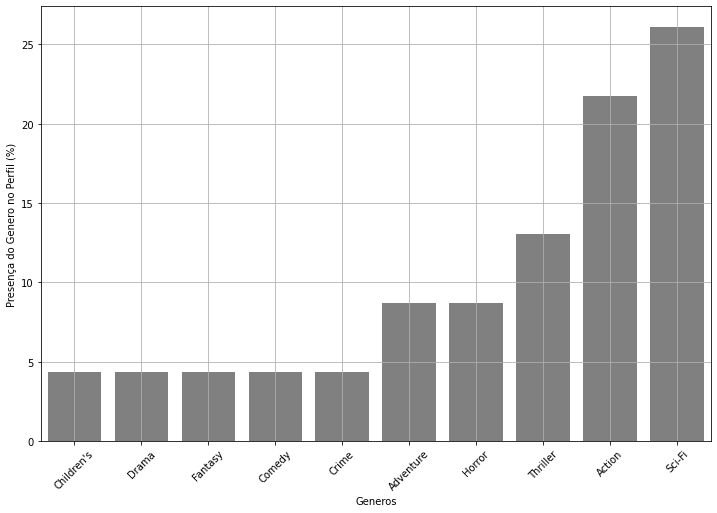

In [9]:
user_profile_distribution = get_user_profile_distribution(train, 522)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=[i[0] for i in user_profile_distribution.items()],
    y=[i[1]*100 for i in user_profile_distribution.items()], color='gray'
)
plt.xticks(rotation=45)
plt.xlabel("Generos")
plt.ylabel("Presença do Genero no Perfil (%)")
plt.grid()
plt.show()

Para o usuário ``305``, temos o gráfico abaixo, que deixa claro que tal usuário assiste, em sua maioria, filmes de Horror, Comédia e Musical.




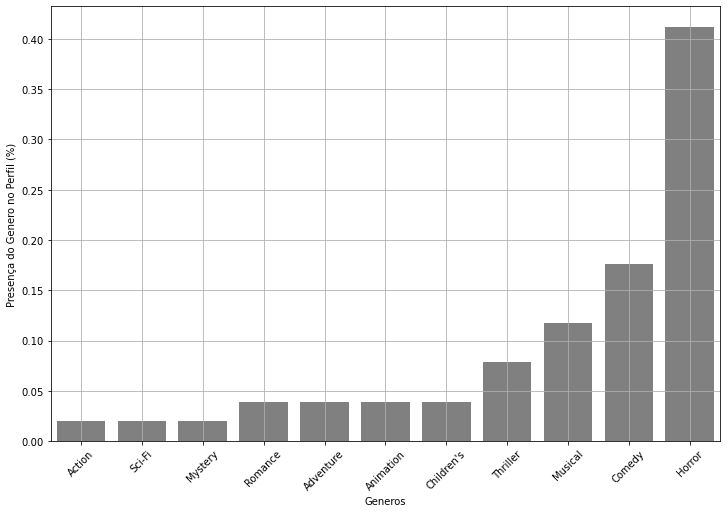

In [10]:
user_profile_distribution = get_user_profile_distribution(train, 305)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=[i[0] for i in user_profile_distribution.items()],
    y=[i[1] for i in user_profile_distribution.items()], color='gray'
)
plt.xticks(rotation=45)
plt.xlabel("Generos")
plt.ylabel("Presença do Genero no Perfil (%)")
plt.grid()
plt.show()

## 5. Recomendação
Nessa etapa vamos visualizar como o modelo ``User-based KNN`` lida a questão estudada por Steck e descrita no começo do notebook! Para explorar isso vamos criar um modelo básico, treiná-lo e gerar uma recomendação com o top-10 itens para cada usuário.



In [11]:
from  surprise.prediction_algorithms.slope_one import SlopeOne

reader = Reader(rating_scale = (0, 5))

trainset = Dataset.load_from_df(
    train[["user", "item", "rating"]], reader=reader
).build_full_trainset()

userknn = KNNBasic(K=10, sim_options={"user_based": True, "similarities": 'cosine'})
userknn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [12]:
new_predictions = []
prediction_user_map = {}
data_p2 = []

for user in tqdm.tqdm(sorted(test['user'].unique())[:500]):
    data = {"item": list(set(df["item"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["rating"] = 0.0
    user_testset_df["user"] = user
    
    testset = (
        Dataset.load_from_df(
            user_testset_df[["user", "item", "rating"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, pred.est)for pred in userknn.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    new_predictions.append(predictions[:10])
    prediction_user_map[user] = predictions[:10]
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.78it/s]


# 6. Comparando os gêneros dos filmes recomendados e de perfil

Após treinar o ``User-based KNN`` e gerar uma lista das top-10 recomendações para alguns usuários, podemos comparar a distribuição de gêneros no perfil e a distribuição de gêneros na lista de recomendação.

Primeiramente, vamos criar um método que pega o perfil do usuário e retorna um dicionário, em que as chaves são o nome dos gêneros e os valores são a proporção de itens assistidos nesse gênero em específico.



In [13]:
def get_user_recommendation_distribution(prediction_user_map):
    user_rec_distribution = {}
    n = 0
    for (item, score) in prediction_user_map:
        for genre in genre_map[item]:
            if genre not in user_rec_distribution:
                user_rec_distribution[genre] = 0
            n += 1
            user_rec_distribution[genre] += 1
            
    user_rec_distribution = {k: v/n for k, v in sorted(user_rec_distribution.items(), key=lambda item: item[1])}
    return user_rec_distribution

Vamos observar as comparações entre distribuições de perfil e de recomendação para o usuário ``305``. Fica claro que o gênero mais recomendado é ``drama``, enquanto o gênero mais assistido pelo usuário é ``Horror``. Além disso, observa-se que a recomendação não respeita o perfil de gostos do usuário.



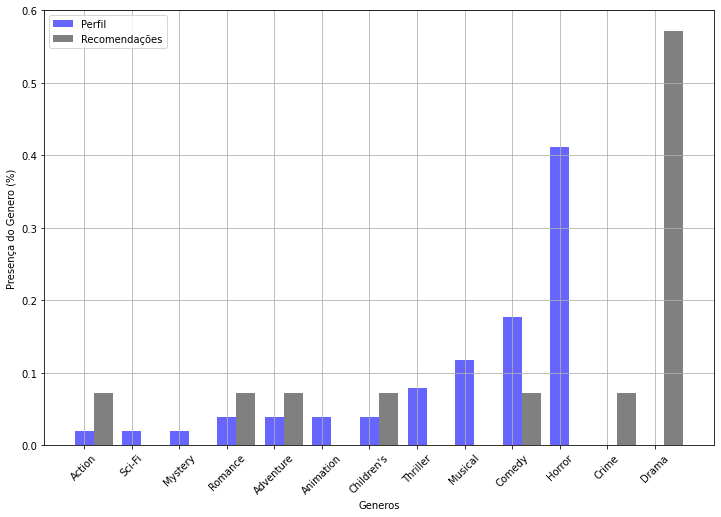

In [14]:
user_rec_distribution = get_user_recommendation_distribution(prediction_user_map[305])
user_profile_distribution = get_user_profile_distribution(train, 305)



plt.figure(figsize=(12, 8))

x_map = {}
n = 0
for genre in user_profile_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2
for genre in user_rec_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2

plt.bar(
    x=[x_map[i[0]] for i in user_profile_distribution.items()],
    height=[i[1] for i in user_profile_distribution.items()],
    color='blue', label="Perfil", width=0.8, alpha=0.6
)

plt.bar(
    x=[x_map[i[0]]+0.8 for i in user_rec_distribution.items()],
    height=[i[1] for i in user_rec_distribution.items()],
    color='gray', label="Recomendações",width=0.8
)

plt.xticks(rotation=45)
plt.xlabel("Generos")
plt.ylabel("Presença do Genero (%)")
plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
plt.grid()
plt.legend()
plt.show()

Vamos observar as comparações entre distribuições de perfil e de recomendação para o usuário ``522``. Fica claro que o gênero mais recomendado é ``drama``, enquanto o gênero mais assistido pelo usuário é ``Sci-Fi``. Além disso, observa-se que a recomendação não respeita o perfil de gostos do usuário.



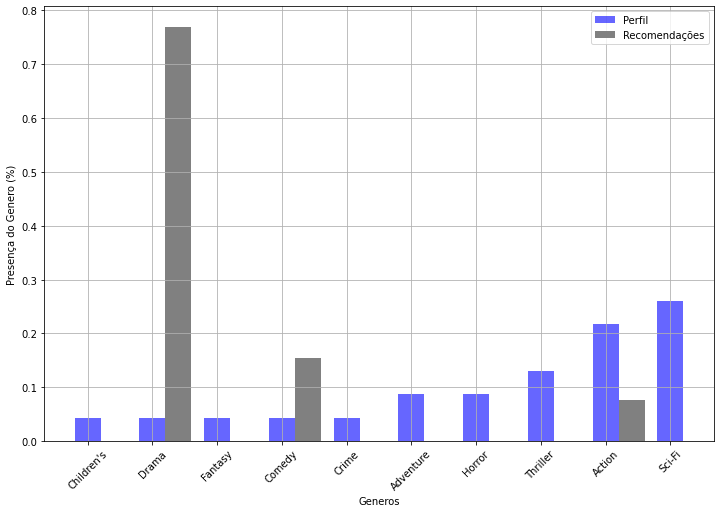

In [15]:
user_rec_distribution = get_user_recommendation_distribution(prediction_user_map[522])
user_profile_distribution = get_user_profile_distribution(train, 522)



plt.figure(figsize=(12, 8))

x_map = {}
n = 0
for genre in user_profile_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2
for genre in user_rec_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2

plt.bar(
    x=[x_map[i[0]] for i in user_profile_distribution.items()],
    height=[i[1] for i in user_profile_distribution.items()],
    color='blue', label="Perfil", width=0.8, alpha=0.6
)

plt.bar(
    x=[x_map[i[0]]+0.8 for i in user_rec_distribution.items()],
    height=[i[1] for i in user_rec_distribution.items()],
    color='gray', label="Recomendações",width=0.8
)

plt.xticks(rotation=45)
plt.xlabel("Generos")
plt.ylabel("Presença do Genero (%)")
plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
plt.grid()
plt.legend()
plt.show()

Nos dois casos atrás, pode-se observar que o modelo de recomendação está privilegiando a recomendação de filmes do gênero ``Drama``, ignorando completamente o gosto do usuário. Esse é o problema que queremos resolver!



## 7. Métricas para Analisar o Problema

Para entender o problema, vamos analisá-lo pelo lado da precisão e pelo lado da injustiça.

### 7.1 Mean Rank Miscalibration

Uma das métricas que vamos usar para medir o quão injusto é o sistema é o Mean Rank Miscalibration, métrica criada por Diego Corrêa da Silva (https://www.sciencedirect.com/science/article/abs/pii/S0957417421005534?via%3Dihub).

Precisamos definir as distribuições ``p`` e ``q``, onde ``p`` é a distribuição de gêneros do perfil do usuário e ``q`` é a distribuição de gêneros das recomendações geradas para o usuário. A função $F$ é usada para calcular a divergência entre as distribuições de gêneros.

A função $RMC$ percorre os itens do usuário e calcula a descalibração para cada fração da lista de recomendação. Além disso, a função $MRMC$ calcula a média de $RMC$ para todos os usuários.

$$
F(p, q) = \sum_g p(g|u)\log_2\frac{p(g|u)}{(1-\alpha)\cdot q(g|u) + \alpha p(g|u)}
$$

$$
MC(p, q) = \frac{F(p, q)}{F(p, {})}
$$

$$
RMC(p, q) = \frac{\sum_i MC(p, q(R^*@i))}{N}
$$

$$
MRMC(p, q) = \frac{\sum_u RMC(u)}{|U|}
$$

A medida $MRMC$ varia no intervalo $[0, 1]$, onde, 1 significa um sistema completamente injusto e 0 significa um sistema completamente justo. Ou seja, esperamos obter valores mais baixos possíveis de $MRMC$ para esse problema.

In [16]:
def user_rank_miscalibration(user_profile_dist, rec_profile_dist, alpha=0.001):
    p_g_u = user_profile_dist
    q_g_u = rec_profile_dist
    
    Ckl = 0
    for genre, p in p_g_u.items():
        q = q_g_u.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if til_q == 0 or p_g_u.get(genre, 0) == 0:
            Ckl = Ckl
        else:
            Ckl += p * np.log2(p / til_q)
    return Ckl

def get_mean_rank_miscalibration(predictions):
    
    MRMC = 0
    
    for user in predictions:
        RMC = 0
        user_profile_dist = get_user_profile_distribution(train, user)
        if user_profile_dist == {}:
            continue
        
        void = user_rank_miscalibration(user_profile_dist, {})
        N = len(predictions[user])
        for i in range(1, N):
            user_rec_dist = get_user_recommendation_distribution(predictions[user][:i])
            kl = user_rank_miscalibration(user_profile_dist, user_rec_dist)
            RMC += kl/void

        MRMC += RMC/N
    
    return MRMC/len(predictions)

MRMC_before = get_mean_rank_miscalibration(prediction_user_map)
MRMC_before

0.5138263713435364

### 7.2 MRR

Avaliar a precisão dos modelos de sistemas de recomendação é uma etapa importante, pois, em resumo, são métricas que vão nos dizer o quão boa são as recomendações para o usuário. Para isso, vamos utilizar a métrica Mean Reciprocal Rank.

Abaixo temos a equação para o cálculo dessa medida. A função $relevant(i,j)$ retorna 1 se o item $j$ for relevante pro usuário $i$ e retorna 0 caso contrario. Aqui definimos como relevante um item que o usuário interagiu anteriormente.

$$MRR = \frac{1}{M} \sum_{i=1}^{M} \sum_{j=1}^{N} \frac{1}{j}\cdot relevant(i,j) $$

A figura abaixo deixa claro o funcionamento da métrica. Veja para o primeiro usuário, temos que somente o 3 item é o relevante, portanto, teremos $RR = \frac{1}{3}$ e assim por diante, realizando a média ao final dos cálculos.


![alt text](https://github.com/Andre-Sacilotti/recsys_lectures/blob/main/images/mrr.png?raw=true)



In [17]:
def item_is_relevant(user_id, item_id):
    aux = train[train["user"] == user_id]
    if item_id in list(aux['item']):
        return True
    return False

def calculate_MRR(map_recommendations):

    MRR = 0
    for user_id in map_recommendations:
        user_find_corerect_item = False
        for index, (item, score) in enumerate(map_recommendations[user_id]):
            if user_find_corerect_item is False:
                if item_is_relevant(user_id, item):
                    MRR += (1/(index+1))
                    user_find_corerect_item = True
        
    return MRR/len(map_recommendations)

MRR_before = calculate_MRR(prediction_user_map)
MRR_before

0.1354896825396827

## 8. Corrigindo o Problema - Calibração

Para tentar corrigir esse problema de gostos de usuários não sendo "respeitado" pelo sistema de recomendação, vamos aplicar a técnica descrita por Steck (https://dl.acm.org/doi/pdf/10.1145/3240323.3240372).

Essa técnica envolve maximizar a expressão descrita abaixo. Essa expressão envolve algumas funções, onde $s(I)$ é a soma dos scores da lista de itens $I$ retornado pelo sistema de recomendação. Enquanto a função $F(p, q(I))$, mede a divergência entre o perfil do usuário $p$ e a recomendação gerada $q$.

Além disso, temos o parâmetro $\lambda$ que pode variar em 0 e 1. Onde 0 estamos considerando apenas a acurácia dita pelo modelo de recomendação e 1 estamos considerando apenas a igualdade de gênero dos filmes recomendados para com o perfil do usuário.

$$
I^* = max_{I} (1-\lambda) s(I) - \lambda F(p, q(I))
$$

Abaixo fizemos a implementação utilizando uma técnica de algoritmo guloso descrito por Steck em seu artigo.



In [18]:
def calculate_calibration_sum(profile_dist, temporary_list_with_score, user, alpha=0.001):
    kl_div = 0.0
    reco_distr = get_user_recommendation_distribution(temporary_list_with_score)
    for genre, p in profile_dist.items():
        q = reco_distr.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if p == 0.0 or til_q == 0.0:
            kl_div = kl_div
        else:
            kl_div = kl_div + (p * np.log2(p / til_q))
    return kl_div


def rerank_recommendation(profile_dist, list_recomended_items, user, N, tradeoff):
    re_ranked_list = []
    re_ranked_with_score = []
    
    for _ in range(N):
        
        max_mmr = -np.inf
        max_item = None
        max_item_rating = None
        
        for item, rating in list_recomended_items:
            if item in re_ranked_list:
                continue
                
            temporary_list = re_ranked_list + [item]
            temporary_list_with_score = re_ranked_with_score + [(item, rating)]
                
            weight_part = sum(
                recomendation[1]
                for recomendation in temporary_list_with_score
            )
            
            full_tmp_calib = calculate_calibration_sum(
                profile_dist,
                temporary_list_with_score,
                user
            )
            
            maximized = (1 - tradeoff)*weight_part - tradeoff*full_tmp_calib
            
            if maximized > max_mmr:
                max_mmr = maximized
                max_item = item
                max_item_rating = rating
            
        if max_item is not None:
            re_ranked_list.append(max_item)
            re_ranked_with_score.append((max_item, max_item_rating))
            
    return re_ranked_list, re_ranked_with_score  

In [19]:
tradeoff = 0.9
N = 10

prediction_user_map_after_calibration = {}

for user in tqdm.tqdm(sorted(test['user'].unique())[:500]):
    
    user_profile_distribution = get_user_profile_distribution(train, user)
    
    data = {"item": list(set(df["item"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["rating"] = 0.0
    user_testset_df["user"] = user
    
    testset = (
        Dataset.load_from_df(
            user_testset_df[["user", "item", "rating"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, pred.est)for pred in userknn.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    
    
    reranked_list = rerank_recommendation(
        user_profile_distribution,
        predictions[:100],
        user,
        N,
        tradeoff
    )
    
    prediction_user_map_after_calibration[user] = reranked_list[1]
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.04it/s]


In [20]:
MRMC_after = get_mean_rank_miscalibration(prediction_user_map_after_calibration)
MRMC_after

0.09975768363075069

In [21]:
MRR_after = calculate_MRR(prediction_user_map_after_calibration)
MRR_after

0.4384547619047618

## 9. Comparação pós Calibração

Vamos comparar os efeitos da calibração!

Primeiro, vamos analisar o usuário ``305``. Vimos anteriormente que a recomendação inicial desse usuário ignorou que ele gosta de filmes de ``Horror`` e recomendou em sua maioria filmes de ``Drama``. No gráfico abaixo, podemos ver uma melhora nas recomendações, ou seja, ``Drama`` deixou de ser recomendado e alguns gêneros passaram a seguir uma distribuição próxima do gosto do usuário.



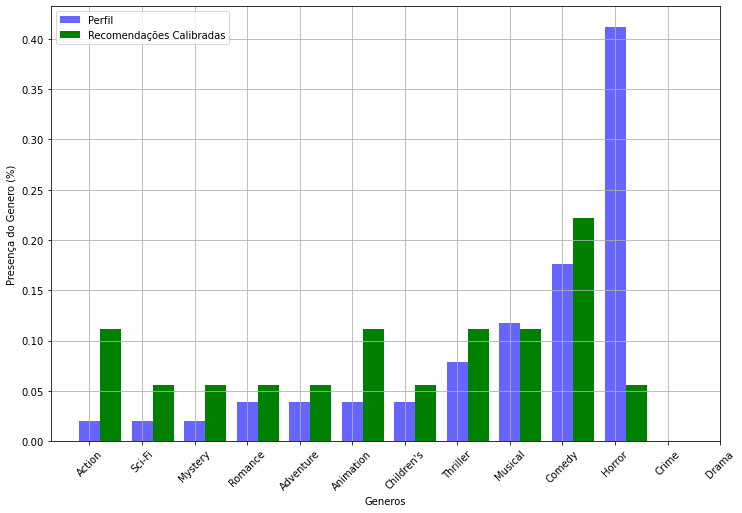

In [22]:
user_rec_distribution = get_user_recommendation_distribution(prediction_user_map[305])
user_rec_distribution_after_calibration = get_user_recommendation_distribution(
    prediction_user_map_after_calibration[305]
)
user_profile_distribution = get_user_profile_distribution(train, 305)



plt.figure(figsize=(12, 8))

x_map = {}
n = 0
for genre in user_profile_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2
for genre in user_rec_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2

plt.bar(
    x=[x_map[i[0]] for i in user_profile_distribution.items()],
    height=[i[1] for i in user_profile_distribution.items()],
    color='blue', label="Perfil", width=.8, alpha=0.6
)

plt.bar(
    x=[x_map[i[0]]+0.8 for i in user_rec_distribution_after_calibration.items()],
    height=[i[1] for i in user_rec_distribution_after_calibration.items()],
    color='green', label="Recomendações Calibradas",width=0.8
)

plt.xticks(rotation=45)
plt.xlabel("Generos")
plt.ylabel("Presença do Genero (%)")
plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
plt.grid()
plt.legend()
plt.show()

Vamos analisar o usuário ``522``. Vimos anteriormente que a recomendação inicial desse usuário ignorou que ele gosta de filmes de ``Sci-Fi`` e recomendou em sua maioria filmes de ``Drama``. No gráfico abaixo, podemos ver uma melhora nas recomendações, onde, os filmes recomendados seguem muito próximo do perfil do usuário!



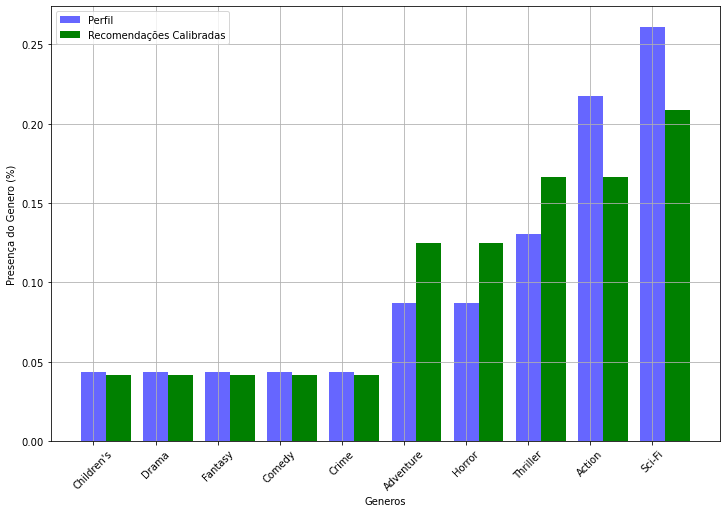

In [23]:
user_rec_distribution = get_user_recommendation_distribution(prediction_user_map[522])
user_rec_distribution_after_calibration = get_user_recommendation_distribution(
    prediction_user_map_after_calibration[522]
)
user_profile_distribution = get_user_profile_distribution(train, 522)



plt.figure(figsize=(12, 8))

x_map = {}
n = 0
for genre in user_profile_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2
for genre in user_rec_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2

plt.bar(
    x=[x_map[i[0]] for i in user_profile_distribution.items()],
    height=[i[1] for i in user_profile_distribution.items()],
    color='blue', label="Perfil", width=.8, alpha=0.6
)

plt.bar(
    x=[x_map[i[0]]+0.8 for i in user_rec_distribution_after_calibration.items()],
    height=[i[1] for i in user_rec_distribution_after_calibration.items()],
    color='green', label="Recomendações Calibradas",width=0.8
)

plt.xticks(rotation=45)
plt.xlabel("Generos")
plt.ylabel("Presença do Genero (%)")
plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
plt.grid()
plt.legend()
plt.show()

Agora, comparando as métricas do sistema, podemos analisar como a calibração impacta na métrica de precisão. No gráfico abaixo, fica fácil ver que a calibração quase triplicou a precisão do modelo, indicando melhores recomendações no geral.



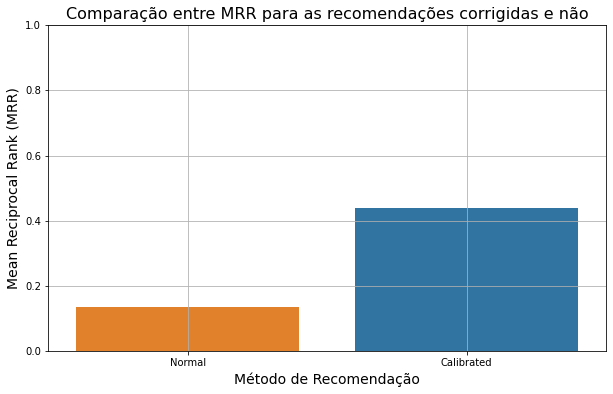

In [24]:
mrr_data = pd.DataFrame(
    {
        'MRR': [MRR_before, MRR_after],
        'tipo': ["Normal", 'Calibrated'],
    }
)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=mrr_data['tipo'],
    y=mrr_data['MRR'],
    palette=[sns.color_palette()[1], sns.color_palette()[0]]
)
plt.xlabel("Método de Recomendação", fontsize=14)
plt.ylabel("Mean Reciprocal Rank (MRR)", fontsize=14)
plt.title("Comparação entre MRR para as recomendações corrigidas e não", fontsize=16)
plt.ylim(0, 1)
plt.grid()

Por fim, comparando a métrica de injustiça, podemos analisar como a calibração impacta na métrica de precisão. No gráfico abaixo, fica fácil ver que a calibração reduziu significativamente a injustiça do sistema, ou seja, temos uma lista de recomendação muito mais justa em relação aos gostos do usuário!



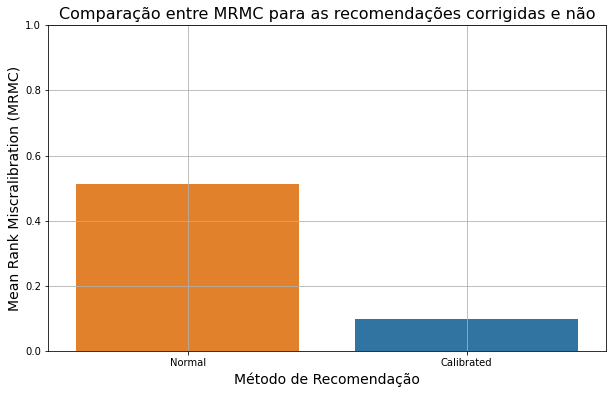

In [25]:
mrr_data = pd.DataFrame(
    {
        'MRMC': [MRMC_before, MRMC_after],
        'tipo': ["Normal", 'Calibrated'],
    }
)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=mrr_data['tipo'],
    y=mrr_data['MRMC'],
    palette=[sns.color_palette()[1], sns.color_palette()[0]]
)
plt.xlabel("Método de Recomendação", fontsize=14)
plt.ylabel("Mean Rank Miscralibration (MRMC)", fontsize=14)
plt.title("Comparação entre MRMC para as recomendações corrigidas e não", fontsize=16)
plt.ylim(0, 1)
plt.grid()

## 10. Referências para Aprofundamento

A área de fairness em sistemas de recomendação é um dos tópicos quentes na área. Nesse notebook analisamos a injustiça relacionado ao gosto do usuário, porem, existem injustiças relacionadas a questões sociais, como educação, nacionalidade, renda, idade e grupos minoritários.

Um bom passo seguinte para quem quer se aprofundar no tema de injustiças em sistemas de recomendação é o Artigo Yashar Deldjoo:

A Survey of Research on Fair Recommender Systems (https://arxiv.org/abs/2205.11127)

